=== Handle imports and paths ===

In [4]:
import sys
sys.path.append('/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/functions/') 
from paths_and_imports import *
from control_flow_functions import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


=== Get the age and sex distributions of the datasets ===

In [2]:
younger_datasets = [ds for ds in datasets if ds['name'] in ['SLIM', 'ID1000']]
younger_stats = get_dataset_statistics(younger_datasets); younger_stats.style.hide(axis="index") # pretraining

repository,set,N,min,max,μ,σ,M:F
SLIM,pretraining,890,17.0,28.4,20.7,1.4,1 / 1.1
ID1000,pretraining,913,19.0,26.0,22.8,1.7,1 / 1.1
All Pretraining,combined,1803,17.0,28.4,21.8,1.9,1 / 1.1


In [3]:
older_datasets = [ds for ds in datasets if ds['name'] in ['UKBB', 'NACC', 'IXI', 'ADNI_CN', 'ADNI_MCI', 'ADNI_AD']]
older_stats = get_dataset_statistics(older_datasets); older_stats.style.hide(axis="index") # training and testing

repository,set,N,min,max,μ,σ,M:F
UKBB,training,9619,45.5,82.4,64.8,7.8,1 / 1.1
NACC,training,4151,18.9,100.2,69.4,10.9,1 / 2.0
IXI,training,480,20.0,86.3,50.9,16.1,1 / 1.3
ADNI_CN,testing,1129,55.5,104.3,75.7,6.8,1 / 1.0
ADNI_AD,testing,477,55.2,93.0,76.1,8.1,1 / 0.9
All Training,combined,14250,18.9,100.2,65.7,9.8,1 / 1.3


=== Display the distribution of ages ===

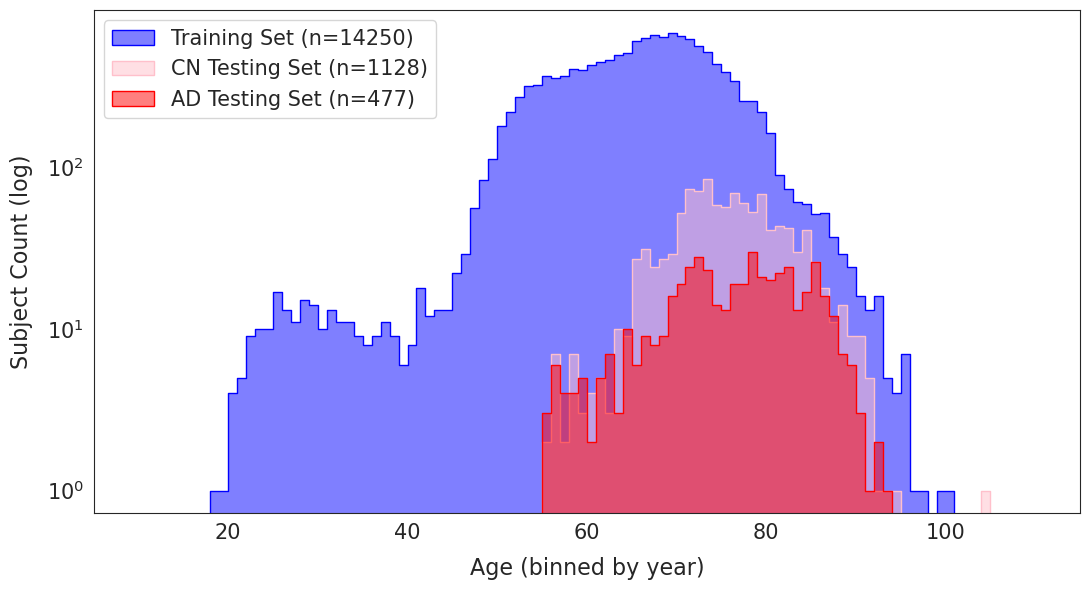

In [3]:
# Load data
y_train_data = np.load(y_train); y_pretrain_data = np.load(y_pretrain)
y_test_CN_data = np.load(y_test_CN); y_test_AD_data = np.load(y_test_AD)

# Set style
sns.set_style("white")

# Create single figure
plt.figure(figsize=(11, 6))

# Compute bins that work for all datasets
min_age = 10
max_age = 110 
bins = np.arange(min_age, max_age + 1, 1)  # Bin from ages 10 to 110, in intervals of 1

# Plot all histograms on the same plot
sns.histplot(y_train_data, label=f'Training Set (n={len(y_train_data)})', 
             element="step", alpha=0.5, color="blue", kde=False, bins=bins)
sns.histplot(y_test_CN_data, label=f'CN Testing Set (n={len(y_test_CN_data)})', 
             element="step", alpha=0.5, color="pink", kde=False, bins=bins)
sns.histplot(y_test_AD_data, label=f'AD Testing Set (n={len(y_test_AD_data)})', 
             element="step", alpha=0.5, color="red", kde=False, bins=bins)

# Add title and labels
plt.xlabel('Age (binned by year)', labelpad=10, size=16)
plt.ylabel('Subject Count (log)', labelpad=10, size=16)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Make semi-log
plt.yscale('log')

plt.tight_layout()
plt.savefig(f'{output_dir}dataset_distributions.png')

=== 5-fold cross-validation using the training data ===

In [2]:
# Run cross-validation (saving done within the code)
avg_mae, per_node_e, chr_ages, age_gaps, pred_per_vertex = run_model(X_train, y_train, X_train, y_train,
                        batch_size=batch_size, batch_load=batch_load, n_epochs=n_train_epochs, lr=lr, 
                        print_every=print_every, ico_levels=[6, 5, 4], first=first, intra_w=intra_w, 
                        global_w=global_w, weight_decay=weight_decay, feature_scale=1, dropout_levels=dropout_levels)


    === Model/Training Params ===

    batch_size = 128
    batch_load = 128
    n_epochs = 25
    lr = 0.01
    L2 regularization = 0
    intra_w = 0.5
    global_w = 1
    feature_scale = 1
    dropout_levels = [0, 0, 0.5, 0.5, 0]

=== Fold 1/5 ===
Train samples: 11400, Test samples: 2850
Epoch: 25, "variance_and_mae" Loss: 118.107
MAE (L1) Loss: 8.210 across 2850 observations
Variance and MAE Loss: 128.075 across 2850 observations

=== Fold 2/5 ===
Train samples: 11400, Test samples: 2850
Epoch: 25, "variance_and_mae" Loss: 118.036
MAE (L1) Loss: 8.145 across 2850 observations
Variance and MAE Loss: 126.880 across 2850 observations

=== Fold 3/5 ===
Train samples: 11400, Test samples: 2850
Epoch: 25, "variance_and_mae" Loss: 118.007
MAE (L1) Loss: 8.534 across 2850 observations
Variance and MAE Loss: 140.812 across 2850 observations

=== Fold 4/5 ===
Train samples: 11400, Test samples: 2850
Epoch: 25, "variance_and_mae" Loss: 118.027
MAE (L1) Loss: 8.418 across 2850 observations
Va

Saved Figure: /mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/5cv_raw_age_gaps.png
Figure stats: mean = 3.082770768863265 ; median = 2.0027617108026377 ; std = 9.083085736853509 ; var = 82.50244650303163
Factors: [-0.89850497 62.10601903]
Saved Figure: /mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/5cv_corrected_age_gaps.png
Figure stats: mean = 1.0583894158467923e-06 ; median = -0.36959152450958754 ; std = 2.230929907407445 ; var = 4.977048251764991

Top 10 significant age gaps:

               region hemi      age_gap variance  skew  region_avg      adj_pval
             G_cuneus   lh  3.14 (6.23)    96.05 -0.26        2.78 2.071408e-158
          G_precuneus   rh  2.93 (6.02)   100.96 -0.22        2.11 1.454080e-135
S_circular_insula_inf   rh -2.85 (0.23)   104.01 -0.15       -2.42 1.049475e-125
  G_and_S_paracentral   rh  2.74 (5.83)   100.15 -0.23        2.53 3.001562e-119
S_circular_insula_sup   rh -2.71 (0.38)   101.47 -0.18       -2.

<Figure size 640x480 with 0 Axes>

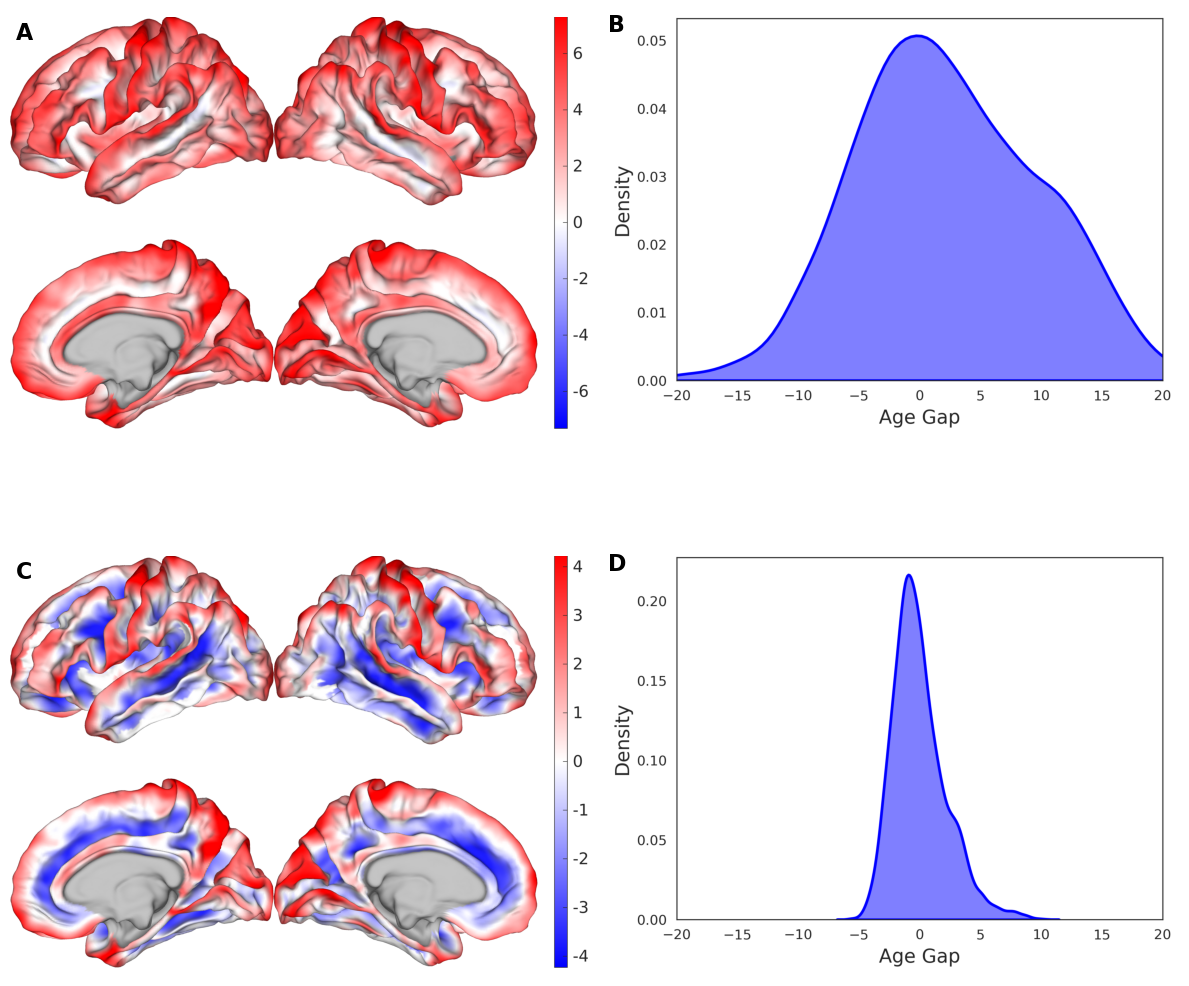

In [3]:
# Load in the 5cv files
fold_output_path = '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/fold_values/'
chr_ages = torch.load(f'{fold_output_path}all_chr_ages.pt').cpu().numpy()
age_gaps = torch.load(f'{fold_output_path}all_age_gaps.pt').cpu().numpy()
pred_per_vertex = torch.load(f'{fold_output_path}all_pred_per_vertex.pt').cpu().numpy()

# Run post-processing
cv_post = postprocess(suffix='5cv')
plot_paths, region_stats_df, _, factors = cv_post(chr_ages, age_gaps, pred_per_vertex)
del cv_post

# Save the factors
np.save(f'{output_dir}5cv_factors', factors)

# Plot the generated images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

# Define subplot labels
subplot_labels = ['A', 'B', 'C', 'D']

# Iterate over the images and their corresponding axes
for ax, path, label in zip(axes, plot_paths, subplot_labels):
    img = mpimg.imread(path)
    ax.imshow(img)
    ax.axis('off')  # Turpred*_per_vertexn off axis labels and ticks
    # Add subplot label in top-left corner
    ax.text(0.01, 0.99, label, transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left', color='black')

plt.tight_layout()  # Adjust layout to prevent overlap

print('\nTop 10 largest errors:'); print(region_stats_df.head(10)); print('\n')
region_stats_df.to_csv(f'{output_dir}5cv_errors.csv', index=True)

=== Train the full model ===

In [3]:
# Train the model
trained_model = run_model(X_train, y_train, None, None,
                        batch_size=batch_size, batch_load=batch_load, n_epochs=n_train_epochs, lr=lr, 
                        print_every=print_every, ico_levels=[6, 5, 4], first=first, intra_w=intra_w, 
                        global_w=global_w, weight_decay=weight_decay, feature_scale=1, dropout_levels=dropout_levels)

# Save the trained model
torch.save(trained_model.state_dict(), f'{output_dir}trained_weights.pth')


    === Model/Training Params ===

    batch_size = 128
    batch_load = 128
    n_epochs = 50
    lr = 0.01
    L2 regularization = 0
    intra_w = 0.5
    global_w = 1
    feature_scale = 1
    dropout_levels = [0, 0, 0.5, 0.5, 0]
    
Epoch: 25, "variance_and_mae" Loss: 112.284
Epoch: 50, "variance_and_mae" Loss: 104.029
